In [ ]:
# Con este Notebook se realizará la carga y procesado de registros logs de la arquitectura
#   de microservicios desarrollada en docker para el sistema de información ADSB
#   Se extrae la información de interés como latencia, recursos CPU, Memoria... y se presenta visualmente

# Se irán recorriendo los distintos archivos y se opera con ellos de manera específica según su contenido

In [1]:
# Importación de librerías necesarias
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
# Carga de archivos
ruta_recursos = "recursos.log"
with open(ruta_recursos, "r") as f:
    recursos_lineas = f.readlines()

In [2]:
ruta_redis="./consumidor_redis/consumidor_redis.log"
with open(ruta_redis, "r") as f:
    redis_lineas = f.readlines()

In [3]:
ruta_cliente_atm="./cliente_atm/cliente_atm.log"
with open(ruta_cliente_atm, "r") as f:
    cliente_atm_lineas = f.readlines()

In [4]:
ruta_cliente_historico="./cliente_historico/cliente_historico.log"
with open(ruta_cliente_historico, "r") as f:
    cliente_historico_lineas = f.readlines()

In [5]:
ruta_mongo="./consumidor_mongo/consumidor_mongo.log"
with open(ruta_mongo, "r") as f:
    mongo_lineas = f.readlines()

In [6]:
ruta_sectorizador="./sectorizador/sectorizador.log"
with open(ruta_sectorizador, "r") as f:
    sectorizador_lineas = f.readlines()

In [7]:
# Función auxiliar para convertir unidades

def convertir_a_bytes(valor):
    """
    Convierte un valor como '3.84kB' o '8.297MiB' a bytes.
    """
    try:
        if valor.endswith("kB"):
            return float(valor.replace("kB", "")) * 1_000
        elif valor.endswith("MiB"):
            return float(valor.replace("MiB", "")) * 1024**2
        elif valor.endswith("GiB"):
            return float(valor.replace("GiB", "")) * 1024**3
        elif valor.endswith("B"):
            return float(valor.replace("B", ""))
        else:
            return float(valor)
    except:
        return None  # Devuelve None si no se puede convertir

# Expresiones regulares para extraer información de interés
aux_insert = re.compile(r'^(.*?) - INFO - (.*?):\s*(\d+)\s+(\w+\s)?insertadas en (.+?)\.?$')
aux_latencia = re.compile(r'^(.*?) - INFO - (.*?)\*\*\*Latencia_(.*?)\*\*\*(.*?)\*\*\*ms')

In [ ]:
# Preprocesado de RECURSOS

# Eliminar líneas vacías o incorrectas. Separar en columnas
recursos_lineas = [linea.strip().split() for linea in recursos_lineas
                   if linea.strip() and not (linea.startswith("CONTAINER") or linea.startswith(" "))]

# DataFrame preliminar
columnas = ["id", "contenedor", "%cpu", "%mem_usada","/1", "mem_total", "%mem_pct", "net_in","/2","net_out", "block_in","/3","block_out", "pids"]
df_recursos_preproc = pd.DataFrame(recursos_lineas, columns=columnas)


# Formateo de tipos
df_recursos_preproc=df_recursos_preproc.drop(columns=["id","/1","/2","block_in","/3","block_out", "pids"])
df_recursos_preproc.head(5)
df_recursos_preproc["%cpu"] = df_recursos_preproc["%cpu"].str.replace('%','').astype(float)
df_recursos_preproc["%mem_pct"] = df_recursos_preproc["%mem_pct"].str.replace('%','').astype(float)
df_recursos_preproc["%mem_usada"] = df_recursos_preproc["%mem_usada"].apply(convertir_a_bytes)
df_recursos_preproc["mem_total"] = df_recursos_preproc["mem_total"].apply(convertir_a_bytes)
df_recursos_preproc["net_in"] = df_recursos_preproc["net_in"].apply(convertir_a_bytes)
df_recursos_preproc["net_out"] = df_recursos_preproc["net_out"].apply(convertir_a_bytes)

columnas = ["%cpu", "%mem_usada", "mem_total", "%mem_pct", "net_in","net_out"]

for col in columnas:
    df_recursos_preproc[col] = pd.to_numeric(df_recursos_preproc[col], errors="coerce")

# Conversión por columnas
df_recursos_preproc["%mem_usada"] = df_recursos_preproc["%mem_usada"] / (1024 ** 2)      # MiB
df_recursos_preproc["mem_total"] = df_recursos_preproc["mem_total"] / (1024 ** 3)        # GiB
df_recursos_preproc["net_in"] = df_recursos_preproc["net_in"] / 1000                     # kB
df_recursos_preproc["net_out"] = df_recursos_preproc["net_out"] / 1000


# Renombrar encabezados con unidad
df_recursos_preproc = df_recursos_preproc.rename(columns={
    "%cpu": "% CPU",
    "%mem_usada": "Memoria usada (MiB)",
    "mem_total": "Memoria total (GiB)",
    "%mem_pct": "% Memoria",
    "net_in": "Entrada de red (kB)",
    "net_out": "Salida de red (kB)"
})

df_recursos=df_recursos_preproc

In [ ]:
# Estadísticas acerca de los recursos

# Estadísticas por contenedor
print("\nEstadísticas por contenedor:")
display(df_recursos.groupby("contenedor").agg({
    "% CPU": ["mean", "max"],
    "Memoria usada (MiB)": ["mean", "max"],
    "Entrada de red (kB)": ["mean", "sum"],
    "Salida de red (kB)": ["mean", "sum"]
}))


In [8]:
# Preprocesado de archivos

# Expresiones de interes que continen "insertadas" y "latencia"
redis_almacenamiento = []
redis_latencias = []

# Extraer líneas de interés
for linea in redis_lineas:
    if match := aux_insert.match(linea):
        timestamp = datetime.strptime(match.group(1), "%Y-%m-%d %H:%M:%S,%f")
        servicio = match.group(2)
        insertadas = int(match.group(3))
        redis_almacenamiento.append((timestamp, servicio, insertadas))
    elif match := aux_latencia.match(linea):
        timestamp = datetime.strptime(match.group(1), "%Y-%m-%d %H:%M:%S,%f")
        servicio = match.group(2)
        tipo = match.group(3)
        if tipo == "ConsumidorRedis":
            tipo=  "Proceso y almacenamiento"
        valor = float(match.group(4))
        redis_latencias.append((timestamp, servicio, tipo, valor))


In [9]:
# Preprocesado de archivos

# Expresiones de interes que continen "latencia"
cliente_atm_almacenamiento = []
cliente_atm_latencias = []

# Extraer líneas de interés
for linea in cliente_atm_lineas:
    if match := aux_insert.match(linea):
        timestamp = datetime.strptime(match.group(1), "%Y-%m-%d %H:%M:%S,%f")
        servicio = match.group(2)
        insertadas = int(match.group(3))
        cliente_atm_almacenamiento.append((timestamp, servicio, insertadas))
    elif match := aux_latencia.match(linea):
        timestamp = datetime.strptime(match.group(1), "%Y-%m-%d %H:%M:%S,%f")
        servicio = match.group(2)
        tipo = match.group(3)
        if tipo == "ClienteATM":
            tipo=  "Latencia"
        valor = float(match.group(4))
        cliente_atm_latencias.append((timestamp, servicio, tipo, valor))

In [10]:
# Preprocesado de archivos

# Expresiones de interes que continen "latencia"
cliente_historico_almacenamiento = []
cliente_historico_latencias = []

# Extraer líneas de interés
for linea in cliente_historico_lineas:
    if match := aux_insert.match(linea):
        timestamp = datetime.strptime(match.group(1), "%Y-%m-%d %H:%M:%S,%f")
        servicio = match.group(2)
        insertadas = int(match.group(3))
        cliente_historico_almacenamiento.append((timestamp, servicio, insertadas))
    elif match := aux_latencia.match(linea):
        timestamp = datetime.strptime(match.group(1), "%Y-%m-%d %H:%M:%S,%f")
        servicio = match.group(2)
        tipo = match.group(3)
        if tipo == "ClienteATM":
            tipo=  "Latencia"
        valor = float(match.group(4))
        cliente_historico_latencias.append((timestamp, servicio, tipo, valor))


In [11]:
# Preprocesado de archivos

# Expresiones de interes que continen "insertadas" y "latencia"
sectorizador_almacenamiento = []
sectorizador_latencias = []

# Extraer líneas de interés
for linea in sectorizador_lineas:
    if match := aux_insert.match(linea):
        timestamp = datetime.strptime(match.group(1), "%Y-%m-%d %H:%M:%S,%f")
        servicio = match.group(2)
        insertadas = int(match.group(3))
        sectorizador_almacenamiento.append((timestamp, servicio, insertadas))
    elif match := aux_latencia.match(linea):
        timestamp = datetime.strptime(match.group(1), "%Y-%m-%d %H:%M:%S,%f")
        servicio = match.group(2)
        tipo = match.group(3)
        if tipo == "Sectorizador":
            tipo=  "Latencia"
        valor = float(match.group(4))
        sectorizador_latencias.append((timestamp, servicio, tipo, valor))

In [12]:
# Preprocesado de archivos

# Expresiones de interes que continen "insertadas" y "latencia"
mongo_almacenamiento = []
mongo_latencias = []

# Extraer líneas de interés
for linea in mongo_lineas:
    if match := aux_insert.match(linea):
        timestamp = datetime.strptime(match.group(1), "%Y-%m-%d %H:%M:%S,%f")
        servicio = match.group(2)
        insertadas = int(match.group(3))
        mongo_almacenamiento.append((timestamp, servicio, insertadas))
    elif match := aux_latencia.match(linea):
        timestamp = datetime.strptime(match.group(1), "%Y-%m-%d %H:%M:%S,%f")
        servicio = match.group(2)
        tipo = match.group(3)
        if tipo == "ConsumidorMongo":
            tipo=  "Proceso y almacenamiento"
        valor = float(match.group(4))
        mongo_latencias.append((timestamp, servicio, tipo, valor))

In [13]:
# Crear DataFrame
df_redis_almacenamiento = pd.DataFrame(redis_almacenamiento, columns=["timestamp", "servicio", "Aeronaves almacenadas"])
df_redis_latencias = pd.DataFrame(redis_latencias, columns=["timestamp", "servicio", "tipo", "valor"])

# Vista preliminar
df_redis_latencias.head()
#df_redis_almacenamiento.head()

,timestamp,servicio,tipo,valor
0,2025-07-08 19:55:31.145,consumidor_redis,mensajeria,825.087547
1,2025-07-08 19:55:31.357,consumidor_redis,Proceso y almacenamiento,217.246056
2,2025-07-08 19:55:40.366,consumidor_redis,mensajeria,73.012829
3,2025-07-08 19:55:40.612,consumidor_redis,Proceso y almacenamiento,245.619774
4,2025-07-08 19:55:40.663,consumidor_redis,mensajeria,350.730181


In [14]:
# Crear DataFrame
df_mongo_almacenamiento = pd.DataFrame(mongo_almacenamiento, columns=["timestamp", "servicio", "Aeronaves almacenadas"])
df_mongo_latencias = pd.DataFrame(mongo_latencias, columns=["timestamp", "servicio", "tipo", "valor"])
# Vista preliminar
df_mongo_latencias.head()
df_mongo_almacenamiento.head()

,timestamp,servicio,Aeronaves almacenadas
0,2025-07-08 19:55:31.702,consumidor_mongo,19
1,2025-07-08 19:55:40.947,consumidor_mongo,98
2,2025-07-08 19:55:42.816,consumidor_mongo,96
3,2025-07-08 19:55:44.119,consumidor_mongo,95
4,2025-07-08 19:55:44.812,consumidor_mongo,97


In [15]:
# Crear DataFrame
df_sectorizador_latencias = pd.DataFrame(sectorizador_latencias, columns=["timestamp", "servicio", "tipo", "valor"])
# Vista preliminar
df_sectorizador_latencias.head()


,timestamp,servicio,tipo,valor
0,2025-07-08 19:52:29.189,,Latencia,253.437757
1,2025-07-08 19:52:39.829,,Latencia,40.748358
2,2025-07-08 19:52:49.940,,Latencia,49.942017
3,2025-07-08 19:53:00.143,,Latencia,143.647671
4,2025-07-08 19:53:10.221,,Latencia,16.590595


In [16]:
# Crear DataFrame
df_cliente_atm_latencias = pd.DataFrame(cliente_atm_latencias, columns=["timestamp", "servicio", "tipo", "valor"])
# Vista preliminar
df_cliente_atm_latencias.head()


,timestamp,servicio,tipo,valor
0,2025-07-08 19:57:40.273,,ClienteATM_estadoatm,322.824240
1,2025-07-08 19:58:18.733,,ClienteATM_sector,47.199488
2,2025-07-08 19:58:51.522,,ClienteATM_aeronave,35.840034
3,2025-07-08 19:58:55.980,,ClienteATM_sector,7.098675
4,2025-07-08 19:59:00.755,,ClienteATM_aeronave,4.321098


In [17]:
# Crear DataFrame
df_cliente_historico_latencias = pd.DataFrame(cliente_historico_latencias, columns=["timestamp", "servicio", "tipo", "valor"])
# Vista preliminar
df_cliente_historico_latencias.head()


,timestamp,servicio,tipo,valor
0,2025-07-08 20:00:03.562,,ClienteHistorico_aeronave,294.37232


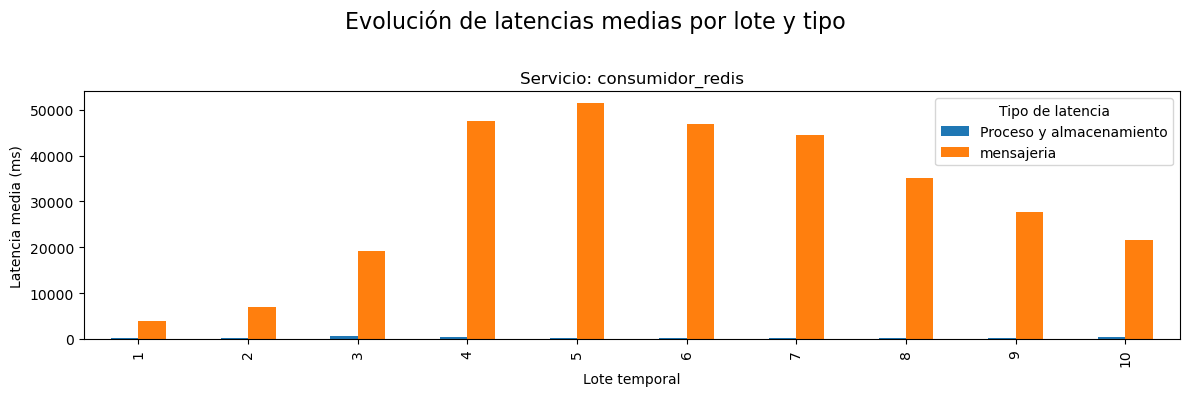

In [18]:
# Visualización de latencias

# Asegurar orden temporal y elegir el dataframe a representar:
df = df_redis_latencias
df_ordenado = df.sort_values("timestamp")

# Contenedor de resultados
resumen = []

# Agrupamos por servicio
for servicio, grupo in df_ordenado.groupby("servicio"):
    grupo = grupo.reset_index(drop=True)
    n = len(grupo)
    lote_size = max(1, n // 10)
    
    # Dividir en 10 bloques
    for i in range(10):
        inicio = i * lote_size
        fin = (i + 1) * lote_size if i < 9 else n  # el último lote incluye el resto
        subgrupo = grupo.iloc[inicio:fin]
        
        # Promedios por tipo dentro de ese lote
        for tipo, sub in subgrupo.groupby("tipo"):
            resumen.append({
                "servicio": servicio,
                "lote": i + 1,
                "tipo": tipo,
                "latencia_media": sub["valor"].mean()
            })

# Convertir a DataFrame
df_resumen = pd.DataFrame(resumen)

# Pivotar para representar
pivot = df_resumen.pivot(index=["servicio", "lote"], columns="tipo", values="latencia_media")

# Asegurar orden de lotes
pivot = pivot.sort_index(level=["servicio", "lote"])

# Crear subplots (uno por servicio)
servicios_unicos = pivot.index.get_level_values("servicio").unique()
fig, axes = plt.subplots(len(servicios_unicos), 1, figsize=(12, 4 * len(servicios_unicos)), sharex=True)

# Normalizar ejes si hay solo uno
if len(pivot.index.get_level_values(0).unique()) == 1:
    axes = [axes]

# Dibujar cada gráfico por servicio
for ax, servicio in zip(axes, servicios_unicos):
    datos = pivot.loc[servicio]
    datos.index = datos.index.astype(int)  # asegurar que 'lote' es numérico en eje X
    datos.plot(kind="bar", ax=ax)
    ax.set_title(f"Servicio: {servicio}")
    ax.set_ylabel("Latencia media (ms)")
    ax.set_xlabel("Lote temporal")
    ax.legend(title="Tipo de latencia")

plt.suptitle("Evolución de latencias medias por lote y tipo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

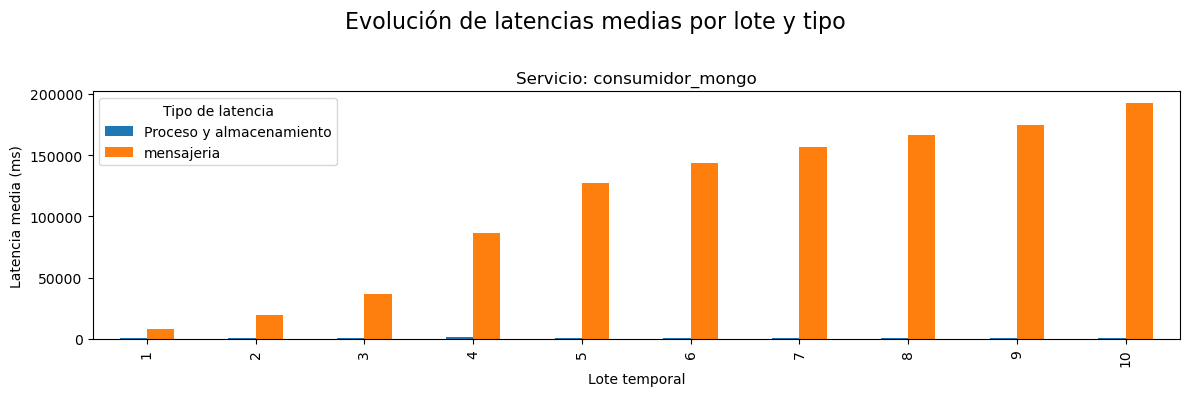

In [19]:
# Visualización de latencias

# Asegurar orden temporal y elegir el dataframe a representar:
df = df_mongo_latencias
df_ordenado = df.sort_values("timestamp")

# Contenedor de resultados
resumen = []

# Agrupamos por servicio
for servicio, grupo in df_ordenado.groupby("servicio"):
    grupo = grupo.reset_index(drop=True)
    n = len(grupo)
    lote_size = max(1, n // 10)
    
    # Dividir en 10 bloques
    for i in range(10):
        inicio = i * lote_size
        fin = (i + 1) * lote_size if i < 9 else n  # el último lote incluye el resto
        subgrupo = grupo.iloc[inicio:fin]
        
        # Promedios por tipo dentro de ese lote
        for tipo, sub in subgrupo.groupby("tipo"):
            resumen.append({
                "servicio": servicio,
                "lote": i + 1,
                "tipo": tipo,
                "latencia_media": sub["valor"].mean()
            })

# Convertir a DataFrame
df_resumen = pd.DataFrame(resumen)

# Pivotar para representar
pivot = df_resumen.pivot(index=["servicio", "lote"], columns="tipo", values="latencia_media")

# Asegurar orden de lotes
pivot = pivot.sort_index(level=["servicio", "lote"])

# Crear subplots (uno por servicio)
servicios_unicos = pivot.index.get_level_values("servicio").unique()
fig, axes = plt.subplots(len(servicios_unicos), 1, figsize=(12, 4 * len(servicios_unicos)), sharex=True)

# Normalizar ejes si hay solo uno
if len(pivot.index.get_level_values(0).unique()) == 1:
    axes = [axes]

# Dibujar cada gráfico por servicio
for ax, servicio in zip(axes, servicios_unicos):
    datos = pivot.loc[servicio]
    datos.index = datos.index.astype(int)  # asegurar que 'lote' es numérico en eje X
    datos.plot(kind="bar", ax=ax)
    ax.set_title(f"Servicio: {servicio}")
    ax.set_ylabel("Latencia media (ms)")
    ax.set_xlabel("Lote temporal")
    ax.legend(title="Tipo de latencia")

plt.suptitle("Evolución de latencias medias por lote y tipo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

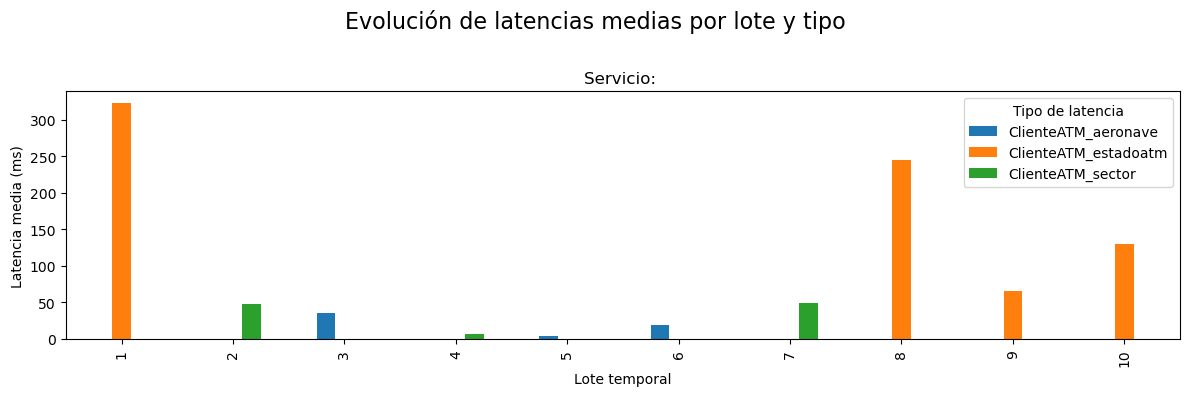

In [20]:
# Visualización de latencias

# Asegurar orden temporal y elegir el dataframe a representar:
df = df_cliente_atm_latencias
df_ordenado = df.sort_values("timestamp")

# Contenedor de resultados
resumen = []

# Agrupamos por servicio
for servicio, grupo in df_ordenado.groupby("servicio"):
    grupo = grupo.reset_index(drop=True)
    n = len(grupo)
    lote_size = max(1, n // 10)
    
    # Dividir en 10 bloques
    for i in range(10):
        inicio = i * lote_size
        fin = (i + 1) * lote_size if i < 9 else n  # el último lote incluye el resto
        subgrupo = grupo.iloc[inicio:fin]
        
        # Promedios por tipo dentro de ese lote
        for tipo, sub in subgrupo.groupby("tipo"):
            resumen.append({
                "servicio": servicio,
                "lote": i + 1,
                "tipo": tipo,
                "latencia_media": sub["valor"].mean()
            })

# Convertir a DataFrame
df_resumen = pd.DataFrame(resumen)

# Pivotar para representar
pivot = df_resumen.pivot(index=["servicio", "lote"], columns="tipo", values="latencia_media")

# Asegurar orden de lotes
pivot = pivot.sort_index(level=["servicio", "lote"])

# Crear subplots (uno por servicio)
servicios_unicos = pivot.index.get_level_values("servicio").unique()
fig, axes = plt.subplots(len(servicios_unicos), 1, figsize=(12, 4 * len(servicios_unicos)), sharex=True)

# Normalizar ejes si hay solo uno
if len(pivot.index.get_level_values(0).unique()) == 1:
    axes = [axes]

# Dibujar cada gráfico por servicio
for ax, servicio in zip(axes, servicios_unicos):
    datos = pivot.loc[servicio]
    datos.index = datos.index.astype(int)  # asegurar que 'lote' es numérico en eje X
    datos.plot(kind="bar", ax=ax)
    ax.set_title(f"Servicio: {servicio}")
    ax.set_ylabel("Latencia media (ms)")
    ax.set_xlabel("Lote temporal")
    ax.legend(title="Tipo de latencia")

plt.suptitle("Evolución de latencias medias por lote y tipo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

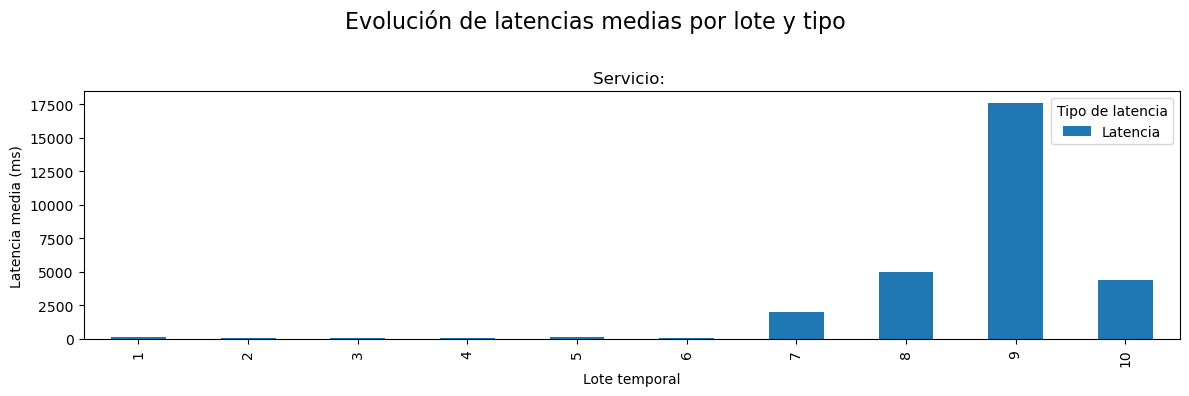

In [21]:
# Visualización de latencias

# Asegurar orden temporal y elegir el dataframe a representar:
df = df_sectorizador_latencias
df_ordenado = df.sort_values("timestamp")

# Contenedor de resultados
resumen = []

# Agrupamos por servicio
for servicio, grupo in df_ordenado.groupby("servicio"):
    grupo = grupo.reset_index(drop=True)
    n = len(grupo)
    lote_size = max(1, n // 10)
    
    # Dividir en 10 bloques
    for i in range(10):
        inicio = i * lote_size
        fin = (i + 1) * lote_size if i < 9 else n  # el último lote incluye el resto
        subgrupo = grupo.iloc[inicio:fin]
        
        # Promedios por tipo dentro de ese lote
        for tipo, sub in subgrupo.groupby("tipo"):
            resumen.append({
                "servicio": servicio,
                "lote": i + 1,
                "tipo": tipo,
                "latencia_media": sub["valor"].mean()
            })

# Convertir a DataFrame
df_resumen = pd.DataFrame(resumen)

# Pivotar para representar
pivot = df_resumen.pivot(index=["servicio", "lote"], columns="tipo", values="latencia_media")

# Asegurar orden de lotes
pivot = pivot.sort_index(level=["servicio", "lote"])

# Crear subplots (uno por servicio)
servicios_unicos = pivot.index.get_level_values("servicio").unique()
fig, axes = plt.subplots(len(servicios_unicos), 1, figsize=(12, 4 * len(servicios_unicos)), sharex=True)

# Normalizar ejes si hay solo uno
if len(pivot.index.get_level_values(0).unique()) == 1:
    axes = [axes]

# Dibujar cada gráfico por servicio
for ax, servicio in zip(axes, servicios_unicos):
    datos = pivot.loc[servicio]
    datos.index = datos.index.astype(int)  # asegurar que 'lote' es numérico en eje X
    datos.plot(kind="bar", ax=ax)
    ax.set_title(f"Servicio: {servicio}")
    ax.set_ylabel("Latencia media (ms)")
    ax.set_xlabel("Lote temporal")
    ax.legend(title="Tipo de latencia")

plt.suptitle("Evolución de latencias medias por lote y tipo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

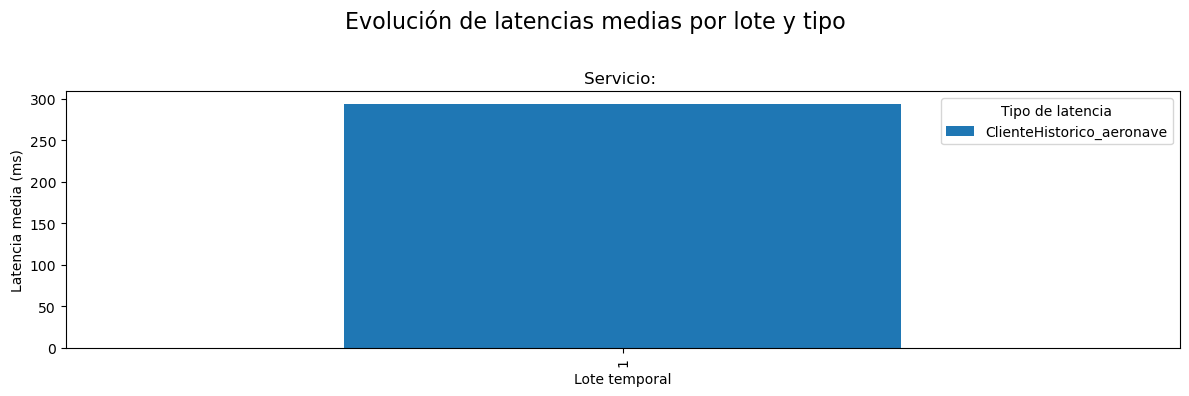

In [22]:
# Visualización de latencias

# Asegurar orden temporal y elegir el dataframe a representar:
df = df_cliente_historico_latencias
df_ordenado = df.sort_values("timestamp")

# Contenedor de resultados
resumen = []

# Agrupamos por servicio
for servicio, grupo in df_ordenado.groupby("servicio"):
    grupo = grupo.reset_index(drop=True)
    n = len(grupo)
    lote_size = max(1, n // 10)
    
    # Dividir en 10 bloques
    for i in range(10):
        inicio = i * lote_size
        fin = (i + 1) * lote_size if i < 9 else n  # el último lote incluye el resto
        subgrupo = grupo.iloc[inicio:fin]
        
        # Promedios por tipo dentro de ese lote
        for tipo, sub in subgrupo.groupby("tipo"):
            resumen.append({
                "servicio": servicio,
                "lote": i + 1,
                "tipo": tipo,
                "latencia_media": sub["valor"].mean()
            })

# Convertir a DataFrame
df_resumen = pd.DataFrame(resumen)

# Pivotar para representar
pivot = df_resumen.pivot(index=["servicio", "lote"], columns="tipo", values="latencia_media")

# Asegurar orden de lotes
pivot = pivot.sort_index(level=["servicio", "lote"])

# Crear subplots (uno por servicio)
servicios_unicos = pivot.index.get_level_values("servicio").unique()
fig, axes = plt.subplots(len(servicios_unicos), 1, figsize=(12, 4 * len(servicios_unicos)), sharex=True)

# Normalizar ejes si hay solo uno
if len(pivot.index.get_level_values(0).unique()) == 1:
    axes = [axes]

# Dibujar cada gráfico por servicio
for ax, servicio in zip(axes, servicios_unicos):
    datos = pivot.loc[servicio]
    datos.index = datos.index.astype(int)  # asegurar que 'lote' es numérico en eje X
    datos.plot(kind="bar", ax=ax)
    ax.set_title(f"Servicio: {servicio}")
    ax.set_ylabel("Latencia media (ms)")
    ax.set_xlabel("Lote temporal")
    ax.legend(title="Tipo de latencia")

plt.suptitle("Evolución de latencias medias por lote y tipo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [23]:
# Calculo de latencias media
media_servicio_tipo = df_redis_latencias.pivot_table(index="servicio", columns="tipo", values="valor", aggfunc="mean")
min_servicio_tipo = df_redis_latencias.pivot_table(index="servicio", columns="tipo", values="valor", aggfunc="min")
max_servicio_tipo = df_redis_latencias.pivot_table(index="servicio", columns="tipo", values="valor", aggfunc="max")

print("Valor medio de latencias por servicio y tipo:")
print(media_servicio_tipo)
print("")
print("Valor mínimo de latencias por servicio y tipo:")
print(min_servicio_tipo)
print("")
print("Valor máximo de latencias por servicio y tipo:")
print(max_servicio_tipo)


Valor medio de latencias por servicio y tipo:
tipo              Proceso y almacenamiento    mensajeria
servicio                                                
consumidor_redis                316.407499  30456.889794

Valor mínimo de latencias por servicio y tipo:
tipo              Proceso y almacenamiento  mensajeria
servicio                                              
consumidor_redis                 40.826797   61.053276

Valor máximo de latencias por servicio y tipo:
tipo              Proceso y almacenamiento    mensajeria
servicio                                                
consumidor_redis               5884.161234  66963.756084


In [24]:
# Calculo de latencias media
media_servicio_tipo = df_mongo_latencias.pivot_table(index="servicio", columns="tipo", values="valor", aggfunc="mean")
min_servicio_tipo = df_mongo_latencias.pivot_table(index="servicio", columns="tipo", values="valor", aggfunc="min")
max_servicio_tipo = df_mongo_latencias.pivot_table(index="servicio", columns="tipo", values="valor", aggfunc="max")

print("Valor medio de latencias por servicio y tipo:")
print(media_servicio_tipo)
print("")
print("Valor mínimo de latencias por servicio y tipo:")
print(min_servicio_tipo)
print("")
print("Valor máximo de latencias por servicio y tipo:")
print(max_servicio_tipo)


Valor medio de latencias por servicio y tipo:
tipo              Proceso y almacenamiento     mensajeria
servicio                                                 
consumidor_mongo                 772.65417  111492.936775

Valor mínimo de latencias por servicio y tipo:
tipo              Proceso y almacenamiento  mensajeria
servicio                                              
consumidor_mongo                 76.392651   73.679447

Valor máximo de latencias por servicio y tipo:
tipo              Proceso y almacenamiento     mensajeria
servicio                                                 
consumidor_mongo               8118.132591  196682.088614


In [25]:
# Calculo de latencias media
media_servicio_tipo = df_cliente_atm_latencias.pivot_table(index="servicio", columns="tipo", values="valor", aggfunc="mean")
min_servicio_tipo = df_cliente_atm_latencias.pivot_table(index="servicio", columns="tipo", values="valor", aggfunc="min")
max_servicio_tipo = df_cliente_atm_latencias.pivot_table(index="servicio", columns="tipo", values="valor", aggfunc="max")

print("Valor medio de latencias por servicio y tipo:")
print(media_servicio_tipo)
print("")
print("Valor mínimo de latencias por servicio y tipo:")
print(min_servicio_tipo)
print("")
print("Valor máximo de latencias por servicio y tipo:")
print(max_servicio_tipo)


Valor medio de latencias por servicio y tipo:
tipo      ClienteATM_aeronave  ClienteATM_estadoatm  ClienteATM_sector
servicio                                                              
                    19.560814            164.486885          34.557581

Valor mínimo de latencias por servicio y tipo:
tipo      ClienteATM_aeronave  ClienteATM_estadoatm  ClienteATM_sector
servicio                                                              
                     4.321098             54.889202           7.098675

Valor máximo de latencias por servicio y tipo:
tipo      ClienteATM_aeronave  ClienteATM_estadoatm  ClienteATM_sector
servicio                                                              
                    35.840034             322.82424           49.37458


In [26]:
# Calculo de latencias media
media_servicio_tipo = df_cliente_historico_latencias.pivot_table(index="servicio", columns="tipo", values="valor", aggfunc="mean")
min_servicio_tipo = df_cliente_historico_latencias.pivot_table(index="servicio", columns="tipo", values="valor", aggfunc="min")
max_servicio_tipo = df_cliente_historico_latencias.pivot_table(index="servicio", columns="tipo", values="valor", aggfunc="max")

print("Valor medio de latencias por servicio y tipo:")
print(media_servicio_tipo)
print("")
print("Valor mínimo de latencias por servicio y tipo:")
print(min_servicio_tipo)
print("")
print("Valor máximo de latencias por servicio y tipo:")
print(max_servicio_tipo)


Valor medio de latencias por servicio y tipo:
tipo      ClienteHistorico_aeronave
servicio                           
                          294.37232

Valor mínimo de latencias por servicio y tipo:
tipo      ClienteHistorico_aeronave
servicio                           
                          294.37232

Valor máximo de latencias por servicio y tipo:
tipo      ClienteHistorico_aeronave
servicio                           
                          294.37232


In [27]:
# Calculo de latencias media
media_servicio_tipo = df_sectorizador_latencias.pivot_table(index="servicio", columns="tipo", values="valor", aggfunc="mean")
min_servicio_tipo = df_sectorizador_latencias.pivot_table(index="servicio", columns="tipo", values="valor", aggfunc="min")
max_servicio_tipo = df_sectorizador_latencias.pivot_table(index="servicio", columns="tipo", values="valor", aggfunc="max")

print("Valor medio de latencias por servicio y tipo:")
print(media_servicio_tipo)
print("")
print("Valor mínimo de latencias por servicio y tipo:")
print(min_servicio_tipo)
print("")
print("Valor máximo de latencias por servicio y tipo:")
print(max_servicio_tipo)


Valor medio de latencias por servicio y tipo:
tipo         Latencia
servicio             
          3290.288528

Valor mínimo de latencias por servicio y tipo:
tipo      Latencia
servicio          
          4.449606

Valor máximo de latencias por servicio y tipo:
tipo          Latencia
servicio              
          28140.517712
